In [49]:
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from skimage.io import imread
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
from skimage.segmentation import mark_boundaries
from skimage.util import montage
from skimage.morphology import binary_opening, disk, label
import gc; gc.enable() # memory is tight
import sys
import random
import math
import cv2
import json
# from imgaug import augmenters as iaa
from tqdm import tqdm
import glob 

In [50]:
debug = False
DATA_DIR = '../data'
# Directory to save logs and trained model
ROOT_DIR = './'
# Import Mask RCNN
sys.path.append(os.path.join(ROOT_DIR, 'Mask_RCNN'))  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

In [51]:
train_dicom_dir = os.path.join(DATA_DIR, 'sample_img')
COCO_WEIGHTS_PATH = "mask_rcnn_coco.h5"
model_path = './mask_rcnn_airbus_0021.h5'

In [52]:
# The following parameters have been selected to reduce running time for demonstration purposes 
# These are not optimal 

class DetectorConfig(Config):    
    # Give the configuration a recognizable name  
    NAME = 'airbus'
    
    GPU_COUNT = 1
    IMAGES_PER_GPU = 9
    
    BACKBONE = 'resnet50'
    
    NUM_CLASSES = 2  # background and ship classes
    
    IMAGE_MIN_DIM = 384
    IMAGE_MAX_DIM = 384
    RPN_ANCHOR_SCALES = (8, 16, 32, 64)
    TRAIN_ROIS_PER_IMAGE = 64
    MAX_GT_INSTANCES = 14
    DETECTION_MAX_INSTANCES = 10
    DETECTION_MIN_CONFIDENCE = 0.95
    DETECTION_NMS_THRESHOLD = 0.0

    STEPS_PER_EPOCH = 15 if debug else 150
    VALIDATION_STEPS = 10 if debug else 125
    
    ## balance out losses
    LOSS_WEIGHTS = {
        "rpn_class_loss": 30.0,
        "rpn_bbox_loss": 0.8,
        "mrcnn_class_loss": 6.0,
        "mrcnn_bbox_loss": 1.0,
        "mrcnn_mask_loss": 1.2
    }

config = DetectorConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     9
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        10
DETECTION_MIN_CONFIDENCE       0.95
DETECTION_NMS_THRESHOLD        0.0
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 9
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  384
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  384
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [384 384   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 30.0, 'rpn_bbox_loss': 0.8, 'mrcnn_class_loss': 6.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.2}
MASK_POOL_SIZE                 14
MASK_SHAPE             

In [53]:
class InferenceConfig(DetectorConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode='inference', 
                          config=inference_config,
                          model_dir=ROOT_DIR)

# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  ./mask_rcnn_airbus_0021.h5


In [54]:
# set color for class
def get_colors_for_class_ids(class_ids):
    colors = []
    for class_id in class_ids:
        if class_id == 1:
            colors.append((.941, .204, .204))
    return colors

### Plot the loss history

Since we have get the loss history while training the model and have saved all data into a csv file, now we read the file and plot the loss history.

In [56]:
history = pd.read_csv('../output/Mask_RCNN/rcnn_loss_history.csv', sep='\t')
epochs = range(1, len(history['loss'])+1)
history.drop(columns=history.columns[0], axis=0)

,val_loss,val_rpn_class_loss,val_rpn_bbox_loss,val_mrcnn_class_loss,val_mrcnn_bbox_loss,val_mrcnn_mask_loss,loss,rpn_class_loss,rpn_bbox_loss,mrcnn_class_loss,mrcnn_bbox_loss,mrcnn_mask_loss
0,2.230380,0.307393,0.728431,0.354702,0.405307,0.434545,2.600539,0.474698,0.716082,0.328195,0.524490,0.557072
1,2.090096,0.300738,0.716178,0.378185,0.314973,0.380021,2.007680,0.277003,0.584559,0.376498,0.349487,0.420131
2,1.671369,0.189220,0.499031,0.368718,0.255876,0.358518,1.831810,0.216629,0.520571,0.420112,0.287474,0.387018
3,1.642694,0.188287,0.476248,0.330730,0.266835,0.380588,1.705743,0.209393,0.492269,0.361375,0.263588,0.379111
4,1.672136,0.192852,0.443668,0.404018,0.255798,0.375792,1.565256,0.181760,0.472567,0.300765,0.248367,0.361790
5,1.495786,0.144478,0.400166,0.347411,0.247655,0.356069,1.504963,0.164888,0.439047,0.292713,0.244995,0.363313
6,1.425357,0.139931,0.383164,0.283226,0.242302,0.376727,1.456951,0.154917,0.427320,0.269056,0.241498,0.364152
7,1.451773,0.145053,0.423238,0.278926,0.241453,0.363095,1.372017,0.144172,0.397340,0.243170,0.234368,0.352960
8,1.414258,0.150900,0.442022,0.207592,0.243465,0.370273,1.281980,0.128206,0.372476,0.207298,0.223367,0.350626
9,1.320636,0.128243,0.404331,0.208036,0.225029,0.354990,1.332644,0.124602,0.407407,0.205038,0.234546,0.361045


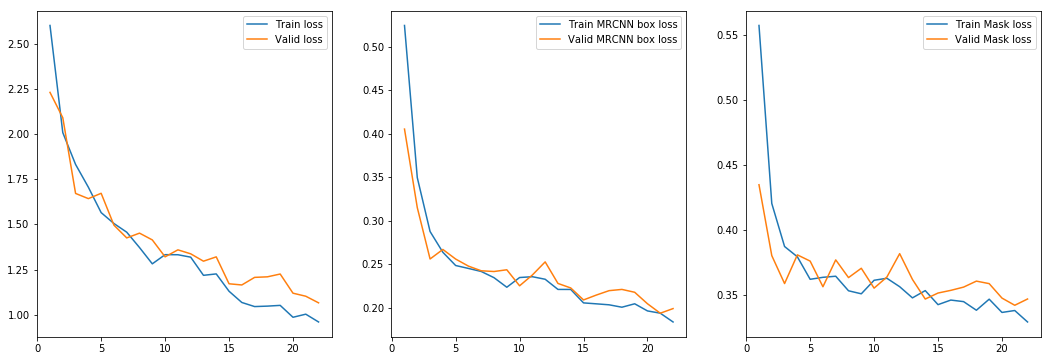

In [57]:
fig = plt.figure(figsize=(18,6))

plt.subplot(131)
plt.plot(epochs, history["loss"], label="Train loss")
plt.plot(epochs, history["val_loss"], label="Valid loss")
plt.legend()
plt.subplot(132)
plt.plot(epochs, history["mrcnn_bbox_loss"], label="Train MRCNN box loss")
plt.plot(epochs, history["val_mrcnn_bbox_loss"], label="Valid MRCNN box loss")
plt.legend()
plt.subplot(133)
plt.plot(epochs, history["mrcnn_mask_loss"], label="Train Mask loss")
plt.plot(epochs, history["val_mrcnn_mask_loss"], label="Valid Mask loss")
plt.legend()

fig.savefig('loss_history_mrcnn.png')
plt.show()


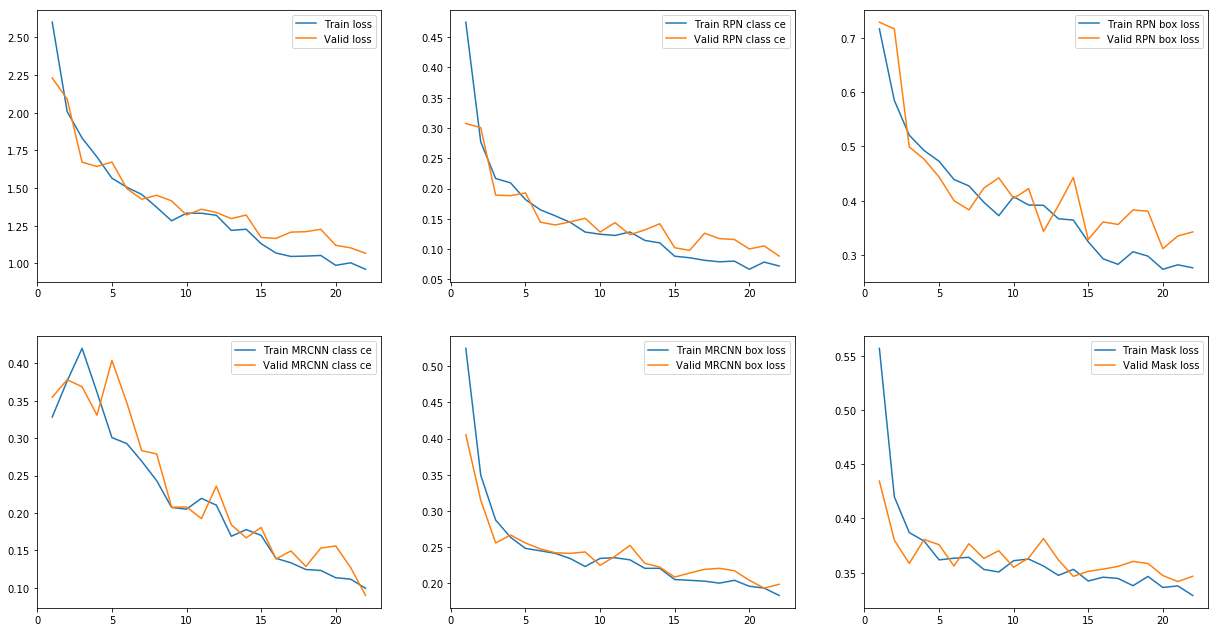

In [58]:
fig = plt.figure(figsize=(21,11))

plt.subplot(231)
plt.plot(epochs, history["loss"], label="Train loss")
plt.plot(epochs, history["val_loss"], label="Valid loss")
plt.legend()
plt.subplot(232)
plt.plot(epochs, history["rpn_class_loss"], label="Train RPN class ce")
plt.plot(epochs, history["val_rpn_class_loss"], label="Valid RPN class ce")
plt.legend()
plt.subplot(233)
plt.plot(epochs, history["rpn_bbox_loss"], label="Train RPN box loss")
plt.plot(epochs, history["val_rpn_bbox_loss"], label="Valid RPN box loss")
plt.legend()
plt.subplot(234)
plt.plot(epochs, history["mrcnn_class_loss"], label="Train MRCNN class ce")
plt.plot(epochs, history["val_mrcnn_class_loss"], label="Valid MRCNN class ce")
plt.legend()
plt.subplot(235)
plt.plot(epochs, history["mrcnn_bbox_loss"], label="Train MRCNN box loss")
plt.plot(epochs, history["val_mrcnn_bbox_loss"], label="Valid MRCNN box loss")
plt.legend()
plt.subplot(236)
plt.plot(epochs, history["mrcnn_mask_loss"], label="Train Mask loss")
plt.plot(epochs, history["val_mrcnn_mask_loss"], label="Valid Mask loss")
plt.legend()

fig.savefig('loss_history.png')

plt.show()